Candidate: Andrés Felipe Bolaños Acosta <br>

Position: Business Intelligence Developer<br>

E-mail: afb.acosta@gmail.com<br>

Mobile phone: +5511973662765<br>

In [2]:
import mysql.connector
import pandas as pd
import seaborn as sns
import warnings
from matplotlib import pyplot as plt

warnings.filterwarnings('ignore')

Connecting to the database:

In [3]:
def connect():
    connection = (mysql.connector.connect(
                               user = 'looqbox-challenge', 
                               password = 'looq-challenge',
                               host = '35.199.127.241',
                               database = 'looqbox_challenge'))
    return connection

conection_database = connect()

# Case 

## A brand new client sent you two ready-to-go queries. Those are listed below:

Query 1:

In [4]:
query_1 = ("SELECT "
              "STORE_CODE, "
              "STORE_NAME, "
              "START_DATE, "
              "END_DATE, "
              "BUSINESS_NAME, "
              "BUSINESS_CODE "
         "FROM data_store_cad ")

Query 2:

In [5]:
query_2 = ("SELECT "
              "STORE_CODE, "
              "DATE, "
              "SALES_VALUE, "
              "SALES_QTY "
         "FROM data_store_sales "
         "WHERE DATE BETWEEN '2019-01-01' AND '2019-12-31' ")

In addition, he gave you this set of instructions:

- You must not modify my queries!
- Please filter the period between this given range:
    - ['2019-10-01','2019-12-31']

<b> ANSWER: </b>

First, it is necessary to execute the queries, which were sent by the client. For this purpose, "pd.read_sql" (it creates a dataframe from a query in the MySQL database) is employed as follows:  

In [6]:
df_store_cad = pd.read_sql(query_1, con = conection_database)
df_store_cad.head()

,STORE_CODE,STORE_NAME,START_DATE,END_DATE,BUSINESS_NAME,BUSINESS_CODE
0,1,Sao Paulo,2006-10-01,,Varejo,1
1,2,Chicago,2007-10-01,,Varejo,1
2,3,Roma,2008-10-01,,Varejo,1
3,4,Tokio,2009-10-01,,Varejo,1
4,5,Paris,2019-01-01,,Proximidade,2


In [7]:
df_store_sales = pd.read_sql(query_2, con = conection_database)
df_store_sales.head()

,STORE_CODE,DATE,SALES_VALUE,SALES_QTY
0,1,2019-01-01,196623.22,12838
1,10,2019-01-01,126795.44,4933
2,11,2019-01-01,223937.00,7724
3,12,2019-01-01,200251.80,7043
4,13,2019-01-01,196623.22,12838


Now, the filter dates ('2019-10-01','2019-12-31') are going to be formated:

In [8]:
filter_date_initial = pd.to_datetime("2019-10-01").date()
filter_date_final = pd.to_datetime("2019-12-31").date()

Then, the filters are going to be applied to the dataframe that resulted from the client's query ("df_query_2").

In [9]:
df_store_sales = df_store_sales[(df_store_sales.DATE 
                                 >= filter_date_initial) 
                                 & (df_store_sales.DATE 
                                    <= filter_date_final)]

Just checking the boundaries of the filters within the dataframe:

In [10]:
df_store_sales.head(3)

,STORE_CODE,DATE,SALES_VALUE,SALES_QTY
5460,1,2019-10-01,187601.54,12160
5461,10,2019-10-01,139038.86,5223
5462,11,2019-10-01,252687.35,8481


In [11]:
df_store_sales.tail(3)

,STORE_CODE,DATE,SALES_VALUE,SALES_QTY
7297,7,2019-12-31,193619.94,12607
7298,8,2019-12-31,191704.64,12500
7299,9,2019-12-31,167081.21,5765


Now, a left join between "df_query_1" and "df_query_2" will be applied. The dataframe "df_query_1", which comes from the table "data_store_cad" in the MySQL database, correspond to the left table because there is a risk that certain shops as well as business areas did not sell products during the filtered period. In that case the values of the right table will represented by NaN values.

In [12]:
df_business_cad = df_store_cad.merge(df_store_sales,
                                     on = "STORE_CODE",
                                     how = "left")
df_business_cad.head(3)

,STORE_CODE,STORE_NAME,START_DATE,END_DATE,BUSINESS_NAME,BUSINESS_CODE,DATE,SALES_VALUE,SALES_QTY
0,1,Sao Paulo,2006-10-01,,Varejo,1,2019-10-01,187601.54,12160
1,1,Sao Paulo,2006-10-01,,Varejo,1,2019-10-02,332666.14,21643
2,1,Sao Paulo,2006-10-01,,Varejo,1,2019-10-03,253401.57,16489


Looking for missing data in the dataframe:

In [13]:
df_business_cad.isna().sum()

STORE_CODE       0
STORE_NAME       0
START_DATE       0
END_DATE         0
BUSINESS_NAME    0
BUSINESS_CODE    0
DATE             0
SALES_VALUE      0
SALES_QTY        0
dtype: int64

There were not NaN values within the merged dataframe's dimensions. This means that values of "STORE_CODE" were in both tables, consequently, the obtained dataframe can be also attained by using an "inner join" instead.

At this time, it is suitable to observe the unique cities and businesses areas to develop some visualizations:

In [14]:
df_business_cad.STORE_NAME.unique()

array(['Sao Paulo', 'Chicago', 'Roma', 'Tokio', 'Paris', 'Berlin',
       'New York', 'Belem', 'London', 'Hong Kong', 'Rio de Janeiro',
       'Madri', 'Dubai', 'Bahia', 'Buenos Aires', 'Salvador', 'Sidney',
       'Bangkok', 'Miami', 'Vancouver'], dtype=object)

In [15]:
df_business_cad.BUSINESS_NAME.unique()

array(['Varejo', 'Proximidade', 'Farma', 'Atacado', 'Posto'], dtype=object)

### Visualizations

#### Per business areas:
##### Sales:

Before plotting a chart the data was grouped by the 'BUSINESS_NAME' in the filtered period.

In [16]:
df_business = df_business_cad[["BUSINESS_NAME",
                               "SALES_VALUE",
                               "SALES_QTY"]].copy()

In [17]:
df_business = df_business.groupby("BUSINESS_NAME",
                                  as_index = True).\
                                  agg({"SALES_VALUE": "sum",
                                       "SALES_QTY": 'sum'})

In [18]:
df_business["SALES_VALUE"] = (df_business["SALES_VALUE"]
                              / 1e+06)

In [19]:
df_business_per = (df_business.div(df_business.
                                   sum(axis = 0), 
                                   axis = 1).multiply(100))

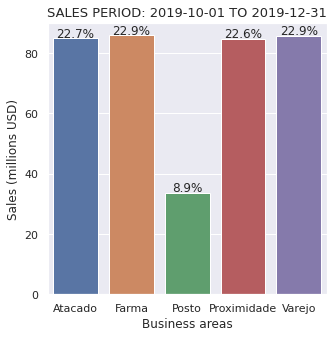

In [20]:
plt.figure(figsize = (5, 5))
sns.set_theme(style = "darkgrid")
fig_obj = sns.barplot(x = df_business.index, 
                      y = df_business.SALES_VALUE,
                      data = df_business)
patches = fig_obj.patches

for patch in range (len(patches)):
    x = (patches[patch].get_x() 
         + patches[patch].get_width() / 2)
    y = patches[patch].get_height() + 0.5
    fig_obj.annotate('{:.1f}%'.format
                     (df_business_per.SALES_VALUE[patch]), 
                     (x, y), ha = 'center')
fig_obj.set_title("SALES PERIOD: 2019-10-01 TO 2019-12-31",
                  fontsize = 13)    
fig_obj.set_xlabel("Business areas")
fig_obj.set_ylabel("Sales (millions USD)")
plt.show()



##### Quantity:

In [21]:
text_percentages = []
for i in range(len(df_business_per.SALES_QTY)):
    round_val = round(df_business_per.SALES_QTY[i], 2)
    text_percentages.append(str(round_val) + "%")

text_x = df_business.index
text_y = (df_business.SALES_QTY / 1e+06
          + 0.05)


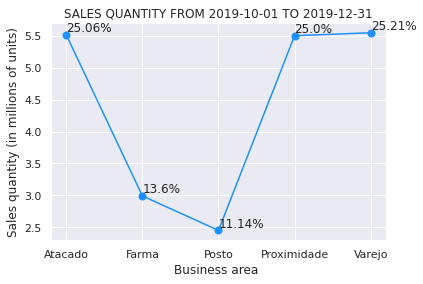

In [22]:
plt.figure(figsize = (6, 4))
plt.title("SALES QUANTITY " 
          "FROM 2019-10-01 TO 2019-12-31")


plt.xlabel("Business area ")
plt.ylabel("Sales quantity (in millions of units)")
plt.plot(df_business.index, df_business.SALES_QTY / 1e+06,
         marker = "o", ms = 7, color = 'dodgerblue',
         lw = 1.5)

for j in range(len(df_business.index)):
    plt.annotate(text_percentages[j], 
                 xy = (text_x[j], text_y[j]))
    
plt.show()

#### Per store: 
##### Sales:

The df_business_cad's procedure was also applied to the dataframe that grouped both sales and quantity concerning the "STORE_NAME" as follows:

In [23]:
df_store_sales = df_business_cad[["STORE_NAME",
                                  "SALES_VALUE",
                                  "SALES_QTY"]].copy()

In [24]:
df_store_sales = (df_store_sales.groupby("STORE_NAME",
                  as_index = True).agg({"SALES_VALUE": "sum",
                                        "SALES_QTY": 'sum'}))


In [25]:
df_store_sales["SALES_VALUE"] = (df_store_sales["SALES_VALUE"]
                                 / 1e+06)

In [26]:
df_store_sales_per = (df_store_sales.div(df_business.
                                         sum(axis = 0), 
                                         axis = 1).multiply(100))

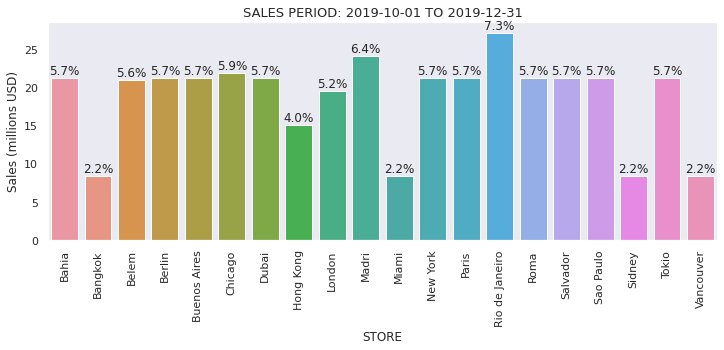

In [27]:
plt.figure(figsize = (12, 4))
sns.set_theme(style = "dark")
fig_obj = sns.barplot(x = df_store_sales.index, 
                      y = df_store_sales.SALES_VALUE,
                      data = df_store_sales)
patches = fig_obj.patches

for patch in range (len(patches)):
    x = (patches[patch].get_x() 
         + patches[patch].get_width() / 2)
    y = patches[patch].get_height() + 0.5
    fig_obj.annotate('{:.1f}%'.format
                     (df_store_sales_per.SALES_VALUE[patch]), 
                     (x, y), ha = 'center')
    
fig_obj.set_title("SALES PERIOD: 2019-10-01 TO 2019-12-31",
                  fontsize = 13)
fig_obj.set_xticklabels(fig_obj.get_xticklabels(),
                        rotation = 90)
fig_obj.set_xlabel("STORE")
fig_obj.set_ylabel("Sales (millions USD)")
plt.show()

##### Quantity:

In [28]:
text_percentages = []
for i in range(len(df_store_sales_per.SALES_QTY)):
    round_val = round(df_store_sales_per.SALES_QTY[i], 2)
    text_percentages.append(str(round_val) + "%")

text_x = df_store_sales.index
text_y = (df_store_sales.SALES_QTY / 1e+06)

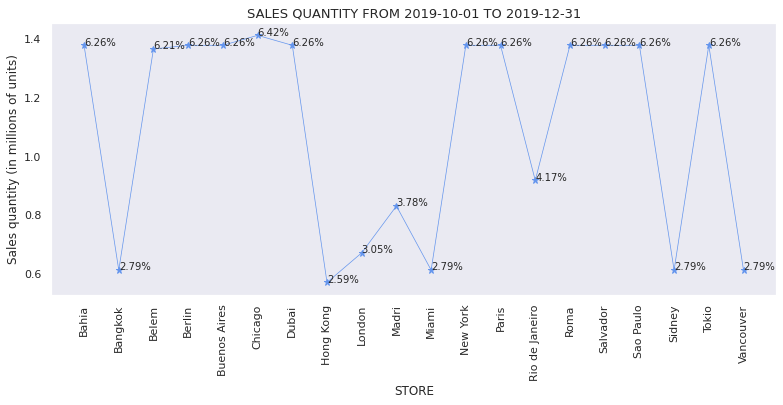

In [29]:
plt.figure(figsize = (13, 5))
plt.title("SALES QUANTITY " 
          "FROM 2019-10-01 TO 2019-12-31",
          fontsize = 13)


plt.xlabel("STORE")
plt.ylabel("Sales quantity (in millions of units)")
plt.plot(df_store_sales.index, 
         df_store_sales.SALES_QTY / 1e+06,
         marker = "*", ms = 7, 
         color = "cornflowerblue",
         lw = 0.7)
plt.xticks(rotation = 90)

for i in range(len(df_store_sales.index)):
    plt.annotate(text_percentages[i], 
                 xy = (text_x[i], text_y[i]),
                 fontsize = 10)
    
plt.show()

#### A dynamic function:

Aside from the previous charts, a dynamic function is implemented "sales_chart", its inputs are "filter_type", which can be defined as "BUSINESS_NAME" or "STORE_NAME". In case of "BUSINESS_NAME", the filter_value is determined by "Varejo", "Atacado", etc. For "STORE_NAME", it receives values such as "Sao Paulo", "Sidney", etc. Finally, the last input corresponds to the table namely as "df_data":

In [33]:
def sales_chart(filter_type, filter_value, df_data):
     df_data = df_data[(df_data[filter_type]
                        == filter_value)]
        
     plt.figure(figsize = (15, 5))
     sns.set_theme(style = "dark")
     fig = sns.lineplot(x = df_data.DATE, 
                        y = (df_data.SALES_VALUE
                             / 1e03),
                        color = "dodgerblue",                       
                        data = df_data)
    
     fig.set_title("Sales of " + filter_value)
     fig.set_xlabel("Date")
     fig.set_ylabel("Sales (thousands USD)")
    
     plt.show()    

In [34]:
df_data = df_business_cad[["DATE", 
                           "STORE_NAME", 
                           "BUSINESS_NAME", 
                           "SALES_VALUE"]].copy()

Illustrating the sales' historical data for the Sao Paulo's store:

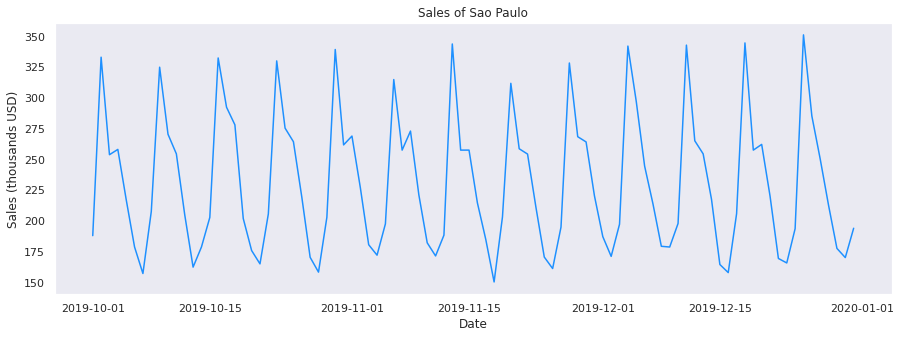

In [35]:
filter_type = "STORE_NAME"
filter_value = "Sao Paulo"
sales_chart(filter_type, filter_value, df_data)

Displaying the sales' historical data for the Sao Paulo's store:


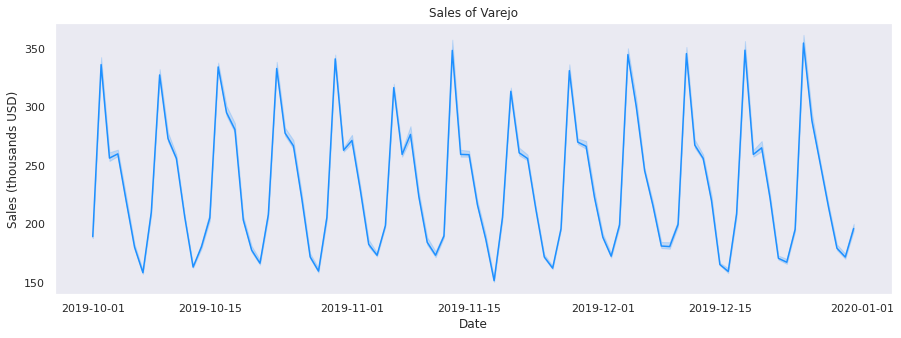

In [36]:
filter_type = "BUSINESS_NAME"
filter_value = "Varejo"
sales_chart(filter_type, filter_value, df_data)